#  Event Dataset Generation
**To enable a fair, repeatable, extensible and realistic experimentation of event-based PdM(Predictive Maintenance) approaches, we develop a configurable generator.**

The dataset produced by the generator is an array, saved as a csv file, of sets of event log identifiers. 



### Setup

In [1]:
#Make the necessary imports.

import numpy as np
import matplotlib.pyplot as plt
import csv
import random
import sys
import pandas as pd

### Init variables

The identifiers range from 1 to ft, where **ft** is the size of the event dictionary,
and are going to be referred as events for the rest of the notebook. 
An event might indicate a specific maintenance process that has taken place or a specific fault.

Variables **str** and **ste** are the number of the daily segments
of the training and test sets, respectively.

To test the accuracy of the PdM techniques, specific patterns of events
of length **pl** from the ft dictionary that precede the target event are infused.

The clarity of the pattern **pc** is distorted in order to emulate the real world cases, where
the preceding indications of a prominent failure are not always exactly the same
or clear. This variable defines the percentage of partial patterns 
(i.e. pattern instances that are missing some of the eventsof the original pattern).

A partial pattern size **pps** defines the percentage of the missing events.

To better map real world cases, the patterns are not deterministic, but each
of the pl elements is linked to **minf**/**maxf** specific events. This
corresponds to the situation, where there are families of faults (event types)
that might precede the target event.

In addition, the distances of the pattern and the target event **mint**/**maxt**
and between pattern events **minp**/**maxp** are also configurable.

The order of the events of the pattern can also be shuffled(**shuffled_pattern**), to allow for higher 
exibility of the supported scenarios.

Another value we have to define is the **max_dist_between_events**, which shows the max number of days that one specific event takes to happened again.

For making the random output to remain the same we define a specific number **seed**.

In [2]:
#Init the variables.
 
n_fault_type=10 #ft=number of fault types

training_days = 20 #str=number of the training days
testing_days = 10 #ste=number of the testing days
 
pattern_length = 3 #pl=pattern length
 
pattern_clarity = 0.9  #pc=pattern clarity
partial_pattern_percentage = 0.5  #pps=the percentage of the missing events in the destored patterns

min_pattern_forms = 1  #minf=min forms of each event of the patterns
max_pattern_forms = 3  #maxf=max forms of each event of the patterns

min_n_days_before_target = 1 #mint=min distance of the pattern from the target event
max_n_days_before_target = 5 #maxt=max distance of the pattern from the target event

min_n_days_between_pattern_events = 1  #minp=min distance between pattern events
max_n_days_between_pattern_events = 2  #maxp=max distance between pattern events

shuffled_pattern = False  #varible that shows if we will shuffle the data

max_dist_between_events = 3 #max distance between events

seed = 4 #if you use the same seed in np.random.RandomState(), then the random output will remain the same

### User's settings

In [3]:
#Setting user's input to the appropriate variables.
for i in range(1, len(sys.argv)):
    arg = sys.argv[i]
    if("--n_fault_type" in arg):
        n_fault_type = int(sys.argv[i+1])
    elif("--training_days" in arg):
        training_days = int(sys.argv[i+1])
    elif("--testing_days" in arg):
        testing_days = int(sys.argv[i+1])
    elif("--min_n_days_before_target" in arg):
        min_n_days_before_target = int(sys.argv[i+1])
    elif("--max_n_days_before_target" in arg):
        max_n_days_before_target = int(sys.argv[i+1])
    elif("--min_n_days_between_pattern_events" in arg):
        min_n_days_between_pattern_events = int(sys.argv[i+1])
    elif("--max_n_days_between_pattern_events" in arg):
        max_n_days_between_pattern_events = int(sys.argv[i+1])
    elif("--max_dist_between_events" in arg):
        max_dist_between_events = int(sys.argv[i+1])
    elif("--partial_pattern_percentage" in arg):
        partial_pattern_percentage = float(sys.argv[i+1])
    elif("--pattern_length" in arg):
        pattern_length = int(sys.argv[i+1])
    elif("--pattern_clarity" in arg):
        pattern_clarity = float(sys.argv[i+1])
    elif("--min_pattern_forms" in arg):
        min_pattern_forms = int(sys.argv[i+1])
    elif("--max_pattern_forms" in arg):
        max_pattern_forms = int(sys.argv[i+1])
    elif("--shuffled_pattern" in arg):
        shuffled_pattern = bool(sys.argv[i+1])
    elif("--seed" in arg):
        seed = int(sys.argv[i+1])     

#### Useful variables
The array size **n_days**=str+ste.

We set a RandomState constant variable **r** to ensure that the random numbers are generated in the same order.

For identifying and standing out the target event(i.e. fault) from the other events we set **target_event** = n_fault_type + 1 

In [4]:
#Other useful variables
n_days = training_days + testing_days #total number of the days we generate= #of training days +  #of testing days
r = np.random.RandomState()
r.seed(seed)
target_event = n_fault_type + 1 #variable for identifying the target event(i.e., fault)

## Generate pattern forms
To genarate pattern forms we make a dictionary named **pattern_dict**. The dictionary contains as ammount of keys as the the length of the pattern(**pl**). Every key has for value a list of numbers. The size of the list is randomly picked from the space [**minf** **maxf**]. The keys are the **last pl events of the fault_types** and this for being near the target event.

In [5]:
#Build the pattern forms->generate_pattern_forms(pattern_events,minf,maxf)
pattern_dict = {}  #pattern dictionary
pattern_num = 1  #init counter of patterns
for p in range(1, pattern_length+1):
    pattern_event = target_event - p
    pattern_dict[pattern_event] = [pattern_event]
    forms = 1
    if max_pattern_forms != 1:
        #random number between [min_pattern_forms,max_pattern_forms]
        forms = r.randint(min_pattern_forms, max_pattern_forms+1)
    for pf in range(1, forms):
        pattern_dict[pattern_event].append(target_event-pattern_length-pattern_num)
        pattern_num += 1

for key,value in pattern_dict.items():
    print(key,value)

10 [10, 7, 6]
9 [9, 5, 4]
8 [8, 3]


### Output's file informations

In [6]:
#Create the output file and write some informations.
ds_type = "training" #dataset's type 
path="C:/Users/Public/ptyxiakh/" #path's name where we save the output file(.csv)
name ="my_dataset2" 

ofile = open(path+ds_type+"_"+name+".csv", "w")
writer = csv.writer(ofile)


writer.writerow(["#target event --> " + str(target_event)])
writer.writerow(["#min different pattern types --> " + str(min_pattern_forms)])
writer.writerow(["#max different pattern types --> " + str(max_pattern_forms)])
writer.writerow(["#pattern forms --> "+str(pattern_dict).replace(",", "")])

55

## Create events
For each event type, a **random normalized Weibull** distribution is
produced. 

Then, we choose random points from this distribution. Each point is used to compute, the daily segment where the event of the specific type is going to be placed. 

This is the main extensibility point of our generator.
Although the Weibull distribution is widely used to map early-life, random or wear-out failures and produce life-usage statistics, someone can implement her own event occurrence distribution function.

In [7]:
#Create events for each day and save the days when target_event happened
target_event_days = []#target evensts list that keeps the days when target_event happened
events = {}  #dictionary events that holds the day->events mapping

#add the target event to the first and last day in order to use all the generated data
events[0] = [target_event]
events[n_days-1] = [target_event]
target_event_days.append(0)
target_event_days.append(n_days-1)

#for each fault_type event and for the target event
for event in range(1, target_event+1): 
    shape = r.uniform(0, 20) #select a random shape for the weibull dist
    dist = r.weibull(shape, 2000).tolist() #create a weibull dist of 2000 points
    
    #if the event is the target event
    if(event == target_event):
        #the target event always follows the same weibull dist
        shape = 50
        dist = r.weibull(shape, 1000).tolist() #create a weibull dist of 1000 points for the target events

    
    minv = min(dist)#min point of the weinbull distribution
    maxv = max(dist)#max point of the weinbull distribution
    
    sum_days = 0
    
    for i in range(0, len(dist)):
        mdbe = max_dist_between_events #max distance between events
        
        #normalize the dist to [0,max_dist_between_events] so that the maximum distance between events 
        #is equal to max_dist_between_events
        if(event == target_event):
            mdbe = 2*max_dist_between_events #max distance between the target events set twice the max distance between events
            dist[i]=int(np.ceil(mdbe*((dist[i]-minv)/(maxv-minv))).astype('int'))
        
        #in case maxv or minv == Inf
        if(dist[i] > mdbe):
            dist[i] = mdbe
        if(dist[i] < 0):
            dist[i] = 0	
        dist[i]=int(np.ceil(dist[i]))

        #every point of the dist is mapped to a range of days, which are added to the total number of days
        sum_days =sum_days+dist[i]#add to sum_days the dist values of the weinbull distribution
        
        #if sum_days is less than all the days(training+testing)
        if(sum_days < n_days):
            
            #if sum_days is a key in the events dictionary(that means that in this day an another event happened before)
            if(sum_days in events.keys()):
                #in order to not allow more than one target_event in the same day.
                if(event != target_event)or((sum_days!=n_days-1)and(sum_days!=0)):events[sum_days].append(event)#I CHANGED IT
                
                #in order to not put twice the same day in the target_event_days list.
                if(event == target_event)and(sum_days!=n_days-1)and(sum_days!=0):target_event_days.append(sum_days)
                    
            #if sum_days is not a key in the events dictionary(that means that this is the first event)
            else:
                events[sum_days] = [event]
                if(event == target_event):
                   target_event_days.append(sum_days)
        else:
             break

events[n_days-1].remove(target_event)
events[n_days-1].append(target_event)                

                
print("Days that the target event happened")
print(target_event_days) 
print("")
print("Day -> day's events")
for key,value in events.items():
    print(key,value) 

Days that the target event happened
[0, 29, 5, 10, 15, 19, 25]

Day -> day's events
0 [11]
29 [1, 2, 3, 4, 5, 6, 8, 9, 10, 11]
2 [1, 2, 3, 4, 6, 7, 8, 9, 10]
4 [1, 2, 3, 4, 5, 6, 7, 10]
5 [1, 2, 3, 4, 8, 9, 10, 11]
7 [1, 2, 3, 4, 5, 6, 7, 8, 10]
8 [1, 2, 4, 5]
9 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
10 [1, 3, 4, 8, 9, 11]
12 [1, 3, 4, 5, 6, 7, 8, 10]
13 [1, 2, 3, 4, 5, 6, 7, 8]
15 [1, 2, 3, 4, 5, 6, 7, 9, 10, 11]
17 [1, 3, 4, 5, 6, 7, 10]
18 [1, 2, 3, 4, 5, 7, 8, 9]
19 [1, 2, 3, 6, 7, 8, 9, 10, 11]
20 [1, 3, 4, 5, 6, 9, 10]
21 [1, 2, 4, 5, 7, 8, 9]
22 [1, 2, 3, 5, 6, 8, 9, 10]
24 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
25 [1, 2, 4, 6, 7, 9, 10, 11]
27 [1, 2, 4, 5, 7, 8, 10]
1 [2, 4, 5, 7, 8, 10]
6 [2, 3, 5, 6, 7, 8, 9, 10]
11 [2, 4, 5, 7, 9, 10]
16 [2, 4, 5, 7, 8]
26 [2, 3, 4, 5, 6, 7, 8]
3 [3, 4, 5, 6, 8]
23 [3, 4, 5, 7, 9, 10]
28 [3, 4, 7, 9]
14 [7, 8, 9, 10]


### Remove the spare days

In [8]:
#If more than the n_days are created remove the spare ones.
keys_of_events=np.array(list(events.keys()))
spare_days = len(events) - n_days
if(spare_days > 0):
        for i in range(n_days-1,n_days+spare_days-1):
                del events[keys_of_events[i]]

#### New output's file information

In [9]:
#Compute and write some new informations at the output file.

#compute mean events per day
sume = 0
for d in events.values():
    sume += len(d)
writer.writerow(["#mean events per day --> " + str(sume/len(events))])

#compute mean frequency of the target event
sumd = 0
for i in range(len(target_event_days)-1,0,-1):
    sumd += target_event_days[i] - target_event_days[i-1]
writer.writerow(["#mean frequency of target event --> " + str(sumd/(len(target_event_days)-1))])

#sort target_event_days list
target_event_days = sorted(target_event_days)
writer.writerow(["#days with target event --> " + str(target_event_days).replace(",","")])

print("#mean events per day -> " + str(sume/len(events)))
print("#mean frequency of target event -> " + str(sumd/(len(target_event_days)-1)))
print("#days with target event -> " + str(target_event_days).replace(",",""))

#mean events per day -> 7.1
#mean frequency of target event -> 4.166666666666667
#days with target event -> [0 5 10 15 19 25 29]


### Select partial days
For making a better real world data generator we distort the clarity of the patterns. So we choose randomly (1-**pc**)100% of the target_event_days(days when the target event takes place) as partial days. The **selected_partial_days**  are going to include only the (**pps**)100% of the events
of the original pattern.

In [10]:
#Select randomly (1-pc)*(#target_event_days) days which will 
#be precede by partial patterns based on the specified clarity.

n_partial_patterns = int(round(len(target_event_days)*(1-pattern_clarity)))
selected_partial_days = r.choice([day for day in target_event_days if (day != 0 and day <= training_days)],n_partial_patterns,replace=False)
writer.writerow(["#days with partial pattern --> " + str(selected_partial_days)])
writer.writerow(["#shuffled pattern events --> " + str(shuffled_pattern)])

print("days with partial pattern -> " + str(selected_partial_days))

days with partial pattern -> [19]


### Boolean Function 

In [11]:
#Function that returns TRUE with propability=prob 
def partial_pattern_clarity_choice(prob):
    return r.rand() < prob

## Add patterns before target events


In [12]:
#Add the pattern before the target events
print("------------------------------------")
for i in range(len(target_event_days)-1,0,-1):
    target_event_day = target_event_days[i]
    
    #find the position of the previous target event
    prev_target_event_day = target_event_days[i-1] 
    #writer.writerow(["#target_event_day --> " + str(target_event_day)])
    print("For the target event: ",str(target_event_day))
    print("\n")
     
    #radomnly pick the day before the target event to begin placing the pattern (descending direction)
    placement_day = target_event_day - r.randint(min_n_days_before_target,max_n_days_before_target+1)
    print("The placement day is: ",placement_day)

    pattern_range = range(1,pattern_length+1)
    
    #shuffle the pattern events order
    if(shuffled_pattern):
        pattern_range = r.choice(range(1,pattern_length+1),pattern_length,replace=False)
 
    placed_pattern_events = 0
    for p in pattern_range:
        
        #find the next day for the pattern
        
        #if a pattern_event is already be placed, radomnly(but within limits) find the next placement day  
        if(placed_pattern_events > 0):
            placement_day -= r.randint(min_n_days_between_pattern_events,max_n_days_between_pattern_events+1)
            print("The placement day is: ",placement_day)
        
        
        #select the pattern event
        pattern_event = target_event - p
        print("The selected pattern event is: ",pattern_event)
        
        #radomnly select one pattern event form from the pattern_dict
        pattern_event = r.choice(pattern_dict[pattern_event],1)[0]
        print("The selected pattern event form is: ",pattern_event)
        
        
        #place the pattern only if it is after the previous target event day
        if(placement_day > prev_target_event_day):
            # check if partial event should be added
            
            #if the target_event_day is in the selected_partial_days there is a propability=1-pps 
            #not to add the pattern event
            if(target_event_day in selected_partial_days):
                
                #With propability=pps add the pattern event form to the selected placement day
                if(partial_pattern_clarity_choice(partial_pattern_percentage)):
                    if(placement_day in events.keys()):
                        events[placement_day].append(pattern_event)
                    else:
                        events[placement_day] = [pattern_event]
                    writer.writerow(["#" + str(pattern_event) + " --> " + str(placement_day)])
                    print("In day " + str(placement_day)+" the event " + str(pattern_event) + " just added")
            
            #if the target_event_day is not in the selected_partial_days just add the pattern event form to the selected placement day
            else: 
                if(placement_day in events.keys()):
                    events[placement_day].append(pattern_event)
                else:
                    events[placement_day] = [pattern_event]
                writer.writerow(["#" + str(pattern_event) + " --> " + str(placement_day)])
                print("In day " + str(placement_day)+" the event " + str(pattern_event) + " just added")
        
        print("\n")
        placed_pattern_events += 1
        
    print("------------------------------------")

------------------------------------
For the target event:  29


The placement day is:  28
The selected pattern event is:  10
The selected pattern event form is:  7
In day 28 the event 7 just added


The placement day is:  27
The selected pattern event is:  9
The selected pattern event form is:  5
In day 27 the event 5 just added


The placement day is:  25
The selected pattern event is:  8
The selected pattern event form is:  3


------------------------------------
For the target event:  25


The placement day is:  20
The selected pattern event is:  10
The selected pattern event form is:  7
In day 20 the event 7 just added


The placement day is:  19
The selected pattern event is:  9
The selected pattern event form is:  4


The placement day is:  17
The selected pattern event is:  8
The selected pattern event form is:  8


------------------------------------
For the target event:  19


The placement day is:  18
The selected pattern event is:  10
The selected pattern event form is:  

## Remove target events
The clarity of the pattern(**pc**) also defines the percentage of the full patterns (i.e.
patterns that include all the events) that are not followed by a target event (i.e.
the target events that follow these patterns are removed from the dataset). More understandable (1-**pc**)100% of the (**pc**)100% of the target event instances(we dont take into account the **selected_partial_days** ) are going to
be removed.

In [13]:
#Remove target events (from non partial pattern cases) to meet the specified clarity

#the number of the events will be removed is (number of target_event_days)*(1-pc)
n_removed_events = int(round(len(target_event_days)*(1-pattern_clarity)))

#radomnly select n_removed_events from the target_event_days that are not partial days and are at training set
r.seed(5)
selected_days = r.choice([day for day in target_event_days if (day not in selected_partial_days and day != 0 and day < training_days)],n_removed_events, replace=False)
for d in selected_days:
    events[d].remove(target_event)
    target_event_days.remove(d)

print("The selected days that the target event will be removed are:")
print(selected_days)

The selected days that the target event will be removed are:
[5]


### Transfer the events to the training and testing files

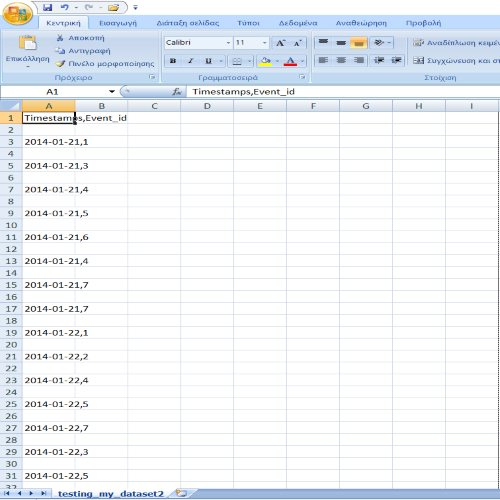

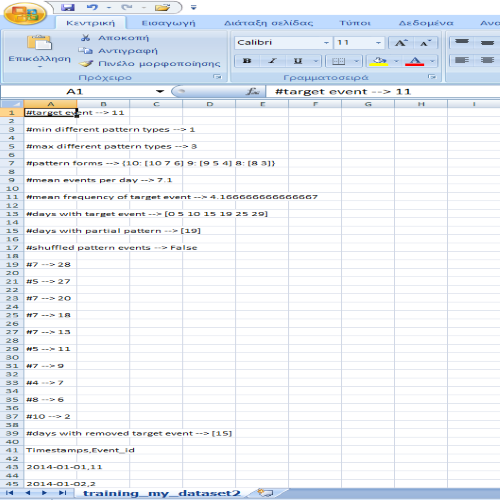

In [14]:
#Write the events to the appropriate training and testing files

writer.writerow(["#days with removed target event --> " + str(selected_days)])
writer.writerow(["Timestamps","Event_id"])

#make a datelist with n_days(=total number of the days we generate) days starting from the day '1/1/2014' 
datelist = pd.date_range(start='1/1/2014', periods=n_days).tolist() 

#counter of the days
days_cnt = 1

for i in range(0,len(events.keys())):
    date = datelist[i]
    
    #if the counter of the days becomes bigger than the training days that meens that the training set file is ready,
    #so save the file and start with the testing set file
    if(days_cnt == training_days+1):
        ofile.close()
        ds_type = "testing"
        ofile = open(path+ds_type+"_"+name+".csv", "w")
        writer = csv.writer(ofile)
        writer.writerow(["Timestamps","Event_id"])
    for event in events[i]:
        #if the event is a pattern event, radomnly select one pattern event form from the pattern_dict
        if(event in pattern_dict):
            event = r.choice(pattern_dict[event],1)[0] 
        writer.writerow([str(date).replace(" 00:00:00",""),event])
    days_cnt += 1


ofile.close()

from IPython.display import Image, display

listOfImageNames = ["C:/Users/Public/ptyxiakh/test_set_screen2.png",
                    "C:/Users/Public/ptyxiakh/train_set_screen2.png"]

for imageName in listOfImageNames:
    display(Image(filename=imageName))